# Time Series and Sentiment Analysis Notebook
This notebook will cover two main sections:
- Time Series Forecasting using the AirPassengers dataset -- downloaded as a CSV.
- Sentiment Analysis using Tweets dataset  -- downloaded as a CSV.


## 📘 Part 1: Time Series Analysis (AirPassengers Dataset)

### Step 1: Import Necessary Libraries
We import essential libraries for data manipulation, visualization, modeling, and evaluation.

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

### Step 2: Load the AirPassengers Dataset
We load the monthly airline passenger data.

In [170]:
df = pd.read_csv('AirPassengers.csv')
df.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Step 3: Preprocessing and Indexing by Time
Convert 'Month' to datetime and set as index for time series operations.

In [173]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### Step 4: Data Visualization
Visualize the time series to observe trends and seasonality.

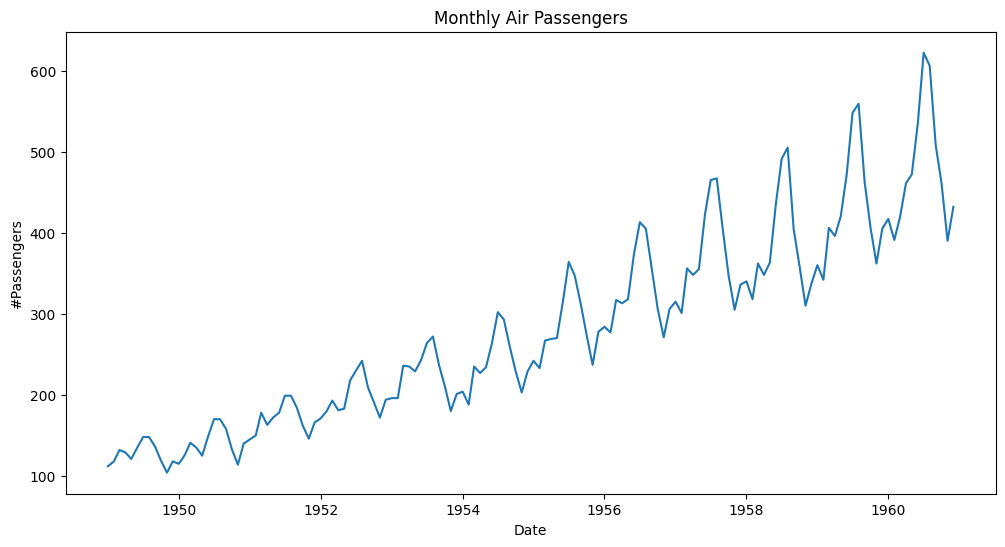

In [176]:
plt.figure(figsize=(12,6))
plt.plot(df['#Passengers'])
plt.title('Monthly Air Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.show()


### Step 5: Descriptive Statistics
Generate basic statistics to understand data distribution.

In [179]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### Step 6: Check Stationarity (ADF Test)
Use Augmented Dickey-Fuller test to check stationarity of the series.

In [182]:
from statsmodels.tsa.stattools import adfuller

# Run the ADF test
result = adfuller(df['#Passengers'])

# Manually print the outputs
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Value 1%:', result[4]['1%'])
print('Critical Value 5%:', result[4]['5%'])
print('Critical Value 10%:', result[4]['10%'])

ADF Statistic: 0.8153688792060371
p-value: 0.9918802434376408
Critical Value 1%: -3.4816817173418295
Critical Value 5%: -2.8840418343195267
Critical Value 10%: -2.578770059171598


### Step 7: Log Transformation
Apply log transformation to stabilize variance.

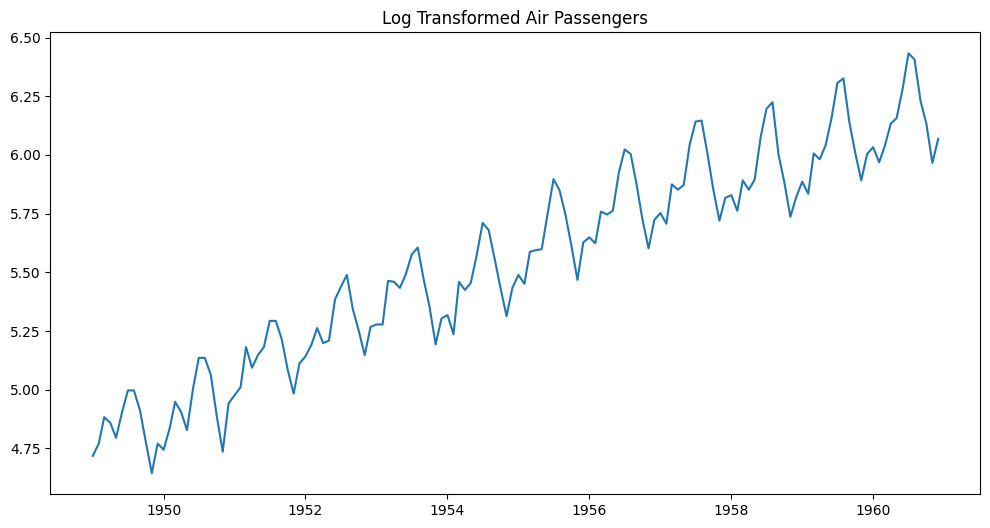

ADF Statistic: -1.7170170891069674
p-value: 0.422366774770388
Critical Value 1%: -3.4816817173418295
Critical Value 5%: -2.8840418343195267
Critical Value 10%: -2.578770059171598


In [185]:
df_log = np.log(df['#Passengers'])
plt.figure(figsize=(12,6))
plt.plot(df_log)
plt.title('Log Transformed Air Passengers')
plt.show()
adf_test(df_log)


### Step 8: Differencing
Apply differencing to remove trends and achieve stationarity.

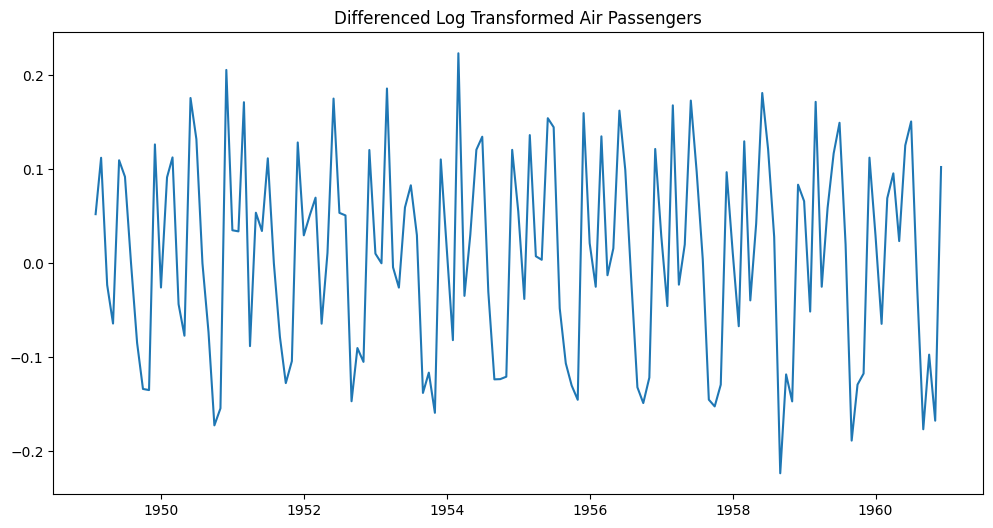

ADF Statistic: -2.7171305983881355
p-value: 0.07112054815085828
Critical Value 1%: -3.4825006939887997
Critical Value 5%: -2.884397984161377
Critical Value 10%: -2.578960197753906


In [188]:
df_log_diff = df_log.diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(df_log_diff)
plt.title('Differenced Log Transformed Air Passengers')
plt.show()
adf_test(df_log_diff)


### Step 9: Decomposition
Decompose the series into trend, seasonal, and residuals.

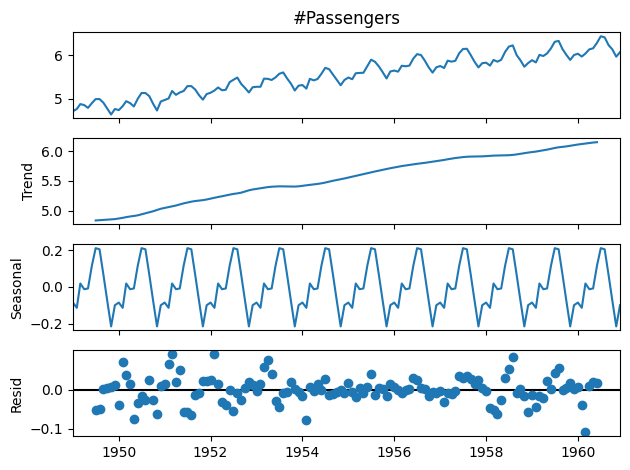

In [191]:
result = seasonal_decompose(df_log, model='additive', period=12)
result.plot()
plt.show()


### Step 10: Plot ACF and PACF
Plot ACF and PACF to determine p and q parameters for ARIMA.

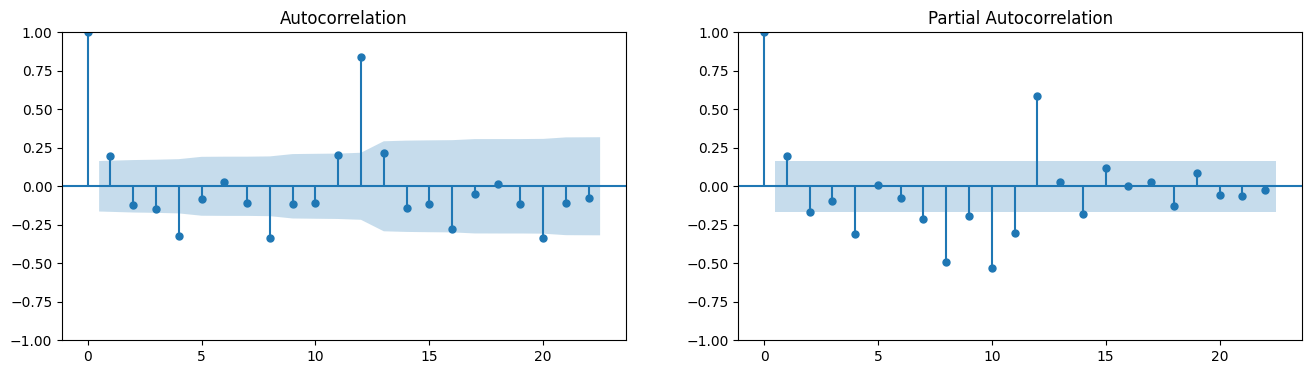

In [194]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(df_log_diff, ax=axes[0])
plot_pacf(df_log_diff, ax=axes[1])
plt.show()


### Step 11: Build ARIMA Model
Build and fit an ARIMA model.

In [197]:
model = ARIMA(df_log, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 128.890
Date:                Sun, 27 Apr 2025   AIC                           -247.780
Time:                        09:49:02   BIC                           -232.965
Sample:                    01-01-1949   HQIC                          -241.760
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2431      0.166      1.469      0.142      -0.081       0.568
ar.L2          0.2677      0.199      1.344      0.179      -0.123       0.658
ma.L1         -0.0867      0.118     -0.732      0.4

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Step 12: Forecast Future Values
Forecast the next 12 periods and revert log transformation.

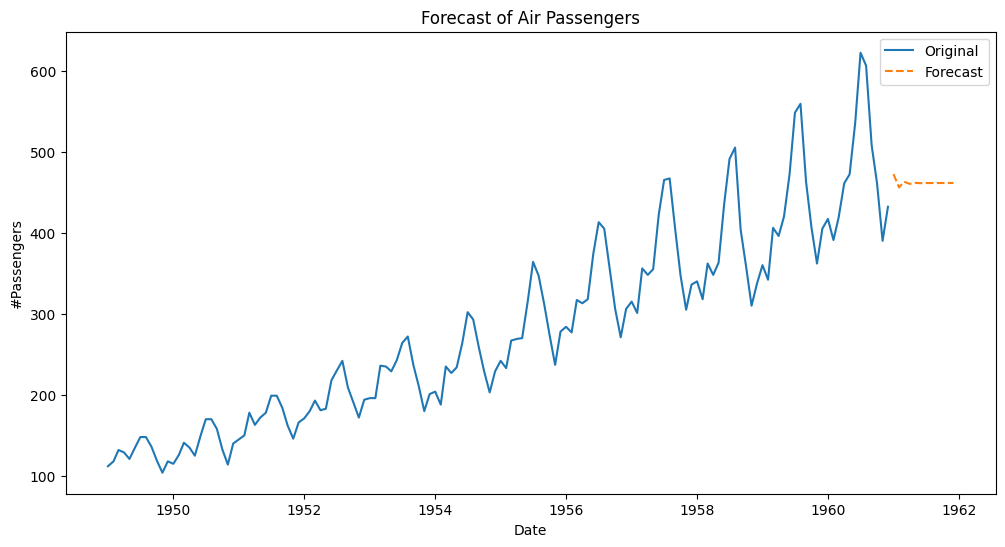

In [200]:
forecast_steps = 12
forecast_log = model_fit.forecast(steps=forecast_steps)
forecast = np.exp(forecast_log)
forecast_dates = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(), periods=forecast_steps, freq='MS')

plt.figure(figsize=(12,6))
plt.plot(df['#Passengers'], label='Original')
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--')
plt.title('Forecast of Air Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.legend()
plt.show()


### Step 13: Evaluate Model Performance
Evaluate the model using MAE and RMSE metrics.

In [203]:
residuals = model_fit.resid
mae = mean_absolute_error(residuals, np.zeros_like(residuals))
rmse = np.sqrt(mean_squared_error(residuals, np.zeros_like(residuals)))

print('MAE:', mae)
print('RMSE:', rmse)


MAE: 0.11667117878345784
RMSE: 0.40519309832452455


## 📗 Part 2: Sentiment Analysis (Tweets Dataset)

### Step 1: Import Necessary Libraries
Libraries for text processing, sentiment analysis, and visualization.

In [207]:
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anasafadar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anasafadar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anasafadar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Step 2: Load Tweets Dataset
Load the Tweets dataset for sentiment analysis.

In [210]:
text_data = pd.read_csv('Tweets.csv')
text_data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Step 3: Basic Text Preprocessing
Clean tweets to remove noise and focus on useful words.

In [213]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Direct split, no punkt needed
text_data['cleaned_text'] = text_data['text'].apply(
    lambda text: ' '.join(
        filter(
            lambda w: w.isalpha() and w not in stop_words,
            text.lower().split()
        )
    )
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anasafadar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 4: Sentiment Analysis at Document Level
Analyze the polarity of each tweet using VADER.

In [216]:
text_data['sentiment_score'] = text_data['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
text_data['sentiment_type'] = text_data['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
text_data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,sentiment_score,sentiment_type
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),,0.0000,neutral
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials,0.0000,neutral
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),must mean need take another,0.0000,neutral
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious faces little...,-0.6318,negative
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing,-0.5829,negative


### Step 5: Generate WordCloud
Visualize most common words used in the tweets.

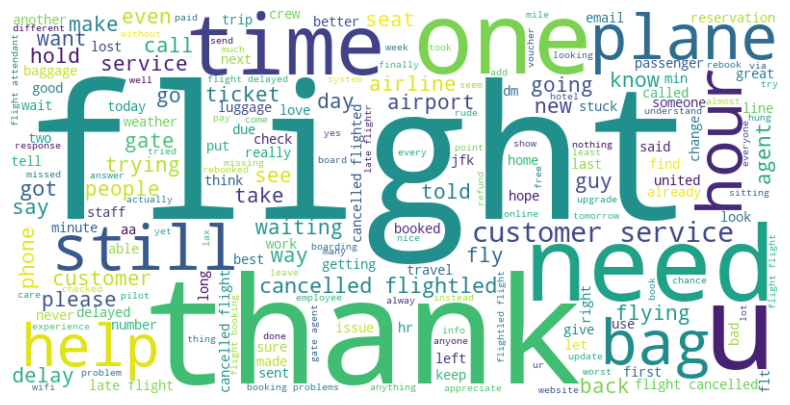

In [219]:
all_text = ' '.join(text_data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Step 6: Sentiment Distribution Bar Plot
Visualize the distribution of positive, negative, and neutral tweets.

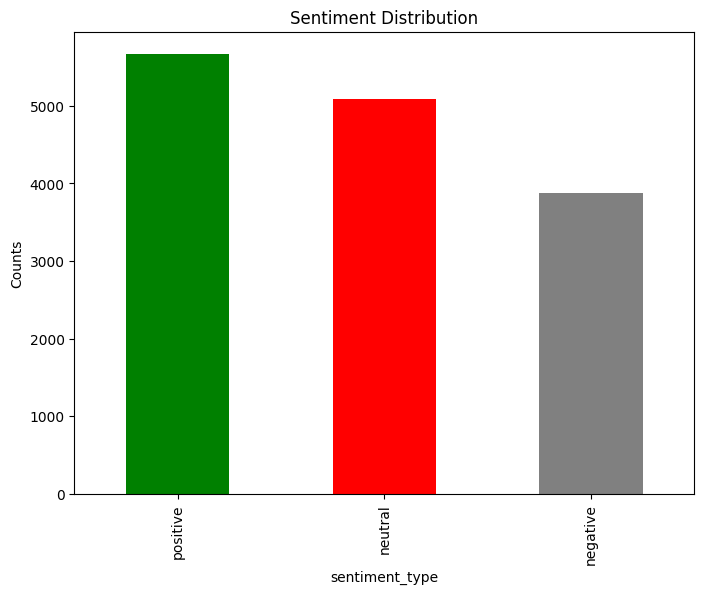

In [222]:
sentiment_counts = text_data['sentiment_type'].value_counts()
sentiment_counts.plot(kind='bar', figsize=(8,6), color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.ylabel('Counts')
plt.show()
